future project:
- don't drop GEOID's in dockless; figure out how they work for more accurate analysis
- add kiosk location by council district in bcycle to match dockless


links: 
- bcycle data: https://data.austintexas.gov/Transportation-and-Mobility/Austin-B-Cycle-Trips/tyfh-5r8s
- dockless data: https://data.austintexas.gov/Transportation-and-Mobility/Dockless-Vehicle-Trips/7d8e-dm7r 
- dockless city council map w/ numbers: http://www.austintexas.gov/GIS/CouncilDistrictMap/
- COA micromobility landing page: https://austintexas.gov/micromobility
- City of Austin District Representatives: https://www.austintexas.gov/government
- battery life, source 1: https://www.cnet.com/news/electric-scooters-bikes-dockless-ride-share-bird-lime-jump-spin-scoot/
- battery life, source 2: https://www.washingtonpost.com/local/trafficandcommuting/scooters-we-answer-your-questions-about-this-latest-transportation-trend/2018/11/10/a94b7d94-de03-11e8-85df-7a6b4d25cfbb_story.html?utm_term=.05c93aa0f747
- ojo/scoot vespa info: https://electrek.co/2019/01/22/ojo-electric-scooters/ 
veoride range info: https://news.uark.edu/articles/46123/veoride-bikeshare-program-adds-150-new-e-assist-bikes 

In [1]:
#Import libraries
from sklearn import preprocessing
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import operator
import seaborn as sns
sns.set_style('white')

#ml algos
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.options.display.max_rows = 30

In [2]:
%autosave 180

Autosaving every 180 seconds


In [3]:
#import csv for Austin B-Cycle Trip data
bcycle = pd.read_csv('Austin_B-Cycle_Trips.csv', encoding='latin1')
bcycle.to_csv('Austin_B-Cycle_Trips.csv.xz', compression='xz')

#import csv for private dockless rideshare co's
dockless = pd.read_csv('Dockless_Vehicle_Trips.csv', encoding='latin1')

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. DATA CLEANING SECTION

# Austin B-Cycle Docked Bikes

## Before the dataset is altered, there are 1,171,610 recorded trips. This value will be used to calculate just how many of the rows dropped after the dataset is cleaned. 

In [4]:
# original number of trips
num_trips = len(bcycle)
print("There are {} trips in this dataset".format(num_trips))

There are 1171610 trips in this dataset


In [5]:
# data clean columns: 
bcycle.columns = bcycle.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

## We can drop Year and Month since ~50% of the values in both colummns are NaN while the Checkout Date are 100% filled.

In [6]:
bcycle.drop(['month', 'year'], 1, inplace=True)

In [7]:
bcycle.head(1)

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes
0,9900285854,Annual (San Antonio B-cycle),207,10/26/2014,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76


## Cleanup -  bicycle_id

In [8]:
bcycle.loc[1077930]

trip_id                                 19000898
membership_type          U.T. Student Membership
bicycle_id                                  303G
checkout_date                         11/18/2018
checkout_time                           22:35:50
checkout_kiosk_id                           2547
checkout_kiosk                  Guadalupe & 21st
return_kiosk_id                             3838
return_kiosk                       Nueces & 26th
trip_duration_minutes                          7
Name: 1077930, dtype: object

In [9]:
bcycle.loc[bcycle.bicycle_id == '318', 'bicycle_id'].count()

0

In [10]:
bcycle['bicycle_id'] = bcycle.bicycle_id.astype(str)

In [11]:
bcycle.bicycle_id.apply(lambda x: type(x)).value_counts()

<class 'str'>    1171610
Name: bicycle_id, dtype: int64

In [12]:
bcycle['bicycle_id'] = bcycle['bicycle_id'].str.replace('G', '')

In [13]:
bcycle['bicycle_id'] = bcycle['bicycle_id'].str.replace('B', '')

In [14]:
bcycle['bicycle_id'] = bcycle['bicycle_id'].str.replace('E', '')
bcycle.bicycle_id.value_counts()

951.0    1896
387.0    1861
885.0    1855
925.0    1852
80.0     1844
696.0    1841
839.0    1840
969.0    1831
60.0     1829
281      1826
660.0    1822
37.0     1810
75.0     1808
185.0    1793
661.0    1790
         ... 
988.0      58
14190      49
987.0      17
579         5
15          5
933         5
483         4
393         4
459         4
195         3
176         3
805         2
165         2
974         1
980         1
Name: bicycle_id, Length: 1008, dtype: int64

In [15]:
bcycle['bicycle_id'] = bcycle.bicycle_id.astype(float)

In [16]:
bcycle['bicycle_id'].value_counts

<bound method IndexOpsMixin.value_counts of 0           207.0
1           969.0
2           214.0
3           745.0
4           164.0
5            37.0
6           517.0
7           996.0
8           517.0
9           385.0
10          133.0
11           52.0
12          206.0
13          241.0
14          478.0
            ...  
1171595     509.0
1171596     575.0
1171597     166.0
1171598      19.0
1171599     287.0
1171600     157.0
1171601     370.0
1171602     203.0
1171603     281.0
1171604     745.0
1171605     451.0
1171606      62.0
1171607     473.0
1171608     461.0
1171609    2197.0
Name: bicycle_id, Length: 1171610, dtype: float64>

In [17]:
#confirmed there are 723 NaN values out of 1.17 M
nan_bicycle_id = bcycle.bicycle_id.isnull().sum(axis=0)
nan_bicycle_id_percent = nan_bicycle_id / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {}."
      .format(nan_bicycle_id, num_trips, nan_bicycle_id_percent))

There are 723 rides with NaN values out of 1171610 total rides, which is equal to 0.0006170995467775113.


## It is safe to say that we can drop the NaN's in these column.

In [18]:
bcycle = bcycle.dropna(axis=0, subset=['bicycle_id'])

## I'm also creating a new dataframe to store the number of drops rows for future reference

In [19]:
dropped_rows = [nan_bicycle_id]

In [20]:
bcycle.isnull().sum()

trip_id                      0
membership_type           6463
bicycle_id                   0
checkout_date                0
checkout_time                0
checkout_kiosk_id        23131
checkout_kiosk               0
return_kiosk_id          24390
return_kiosk                 0
trip_duration_minutes        0
dtype: int64

In [21]:
bcycle['bicycle_id'] = bcycle.bicycle_id.astype(float)

In [22]:
bcycle.bicycle_id.apply(lambda x: type(x)).value_counts()

<class 'float'>    1170887
Name: bicycle_id, dtype: int64

In [23]:
pd.to_numeric(bcycle['bicycle_id'], downcast='float')

0           207.0
1           969.0
2           214.0
3           745.0
4           164.0
5            37.0
6           517.0
7           996.0
8           517.0
9           385.0
10          133.0
11           52.0
12          206.0
13          241.0
14          478.0
            ...  
1171595     509.0
1171596     575.0
1171597     166.0
1171598      19.0
1171599     287.0
1171600     157.0
1171601     370.0
1171602     203.0
1171603     281.0
1171604     745.0
1171605     451.0
1171606      62.0
1171607     473.0
1171608     461.0
1171609    2197.0
Name: bicycle_id, Length: 1170887, dtype: float32

In [24]:
bcycle.dtypes

trip_id                    int64
membership_type           object
bicycle_id               float64
checkout_date             object
checkout_time             object
checkout_kiosk_id        float64
checkout_kiosk            object
return_kiosk_id          float64
return_kiosk              object
trip_duration_minutes      int64
dtype: object

## Cleanup -  return and checkout kiosk ID's

## i need to see list of all columns with NaNs

In [25]:
bcycle.isnull().sum()

trip_id                      0
membership_type           6463
bicycle_id                   0
checkout_date                0
checkout_time                0
checkout_kiosk_id        23131
checkout_kiosk               0
return_kiosk_id          24390
return_kiosk                 0
trip_duration_minutes        0
dtype: int64

In [26]:

nan_checkout_k = bcycle.checkout_kiosk_id.isnull().sum(axis=0)
nan_checkout_kiosk_id_percent = nan_checkout_k / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {}."
      .format(nan_checkout_k, num_trips, nan_checkout_kiosk_id_percent))

There are 23131 rides with NaN values out of 1171610 total rides, which is equal to 0.019742917865159908.


In [27]:
nan_return_k = bcycle.return_kiosk_id.isnull().sum(axis=0)
nan_return_kiosk_id_percent = nan_return_k / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {} percent of the dataframe."
      .format(nan_return_k, num_trips, nan_return_kiosk_id_percent))

There are 24390 rides with NaN values out of 1171610 total rides, which is equal to 0.020817507532369987 percent of the dataframe.


In [28]:
nan_sum_ids = bcycle.apply(lambda row: True if pd.isnull(row['checkout_kiosk_id'])
             or pd.isnull(row['return_kiosk_id']) else False, axis='columns')
nan_sum_ids.sum()
var_sum_ids = nan_sum_ids.sum()

## Altogether, only 3.6% of the dataframe's rows have NaN's values in either the checkout or return kiosk ID, so I'm dropping them. 

In [29]:
percent_kiosks_dropped = var_sum_ids / num_trips
print("There are {} uniquw rows dropped from a total of {}, which is {} percent of the dataset."
      .format(var_sum_ids, num_trips, percent_kiosks_dropped))

There are 42430 uniquw rows dropped from a total of 1171610, which is 0.036215122779764596 percent of the dataset.


In [30]:
dropped_rows = [nan_checkout_k, nan_return_k]
print(dropped_rows)

[23131, 24390]


In [31]:
bcycle = bcycle.dropna(axis=0, subset=['checkout_kiosk_id', 'return_kiosk_id'])

In [32]:
bcycle.isnull().sum()

trip_id                     0
membership_type          6366
bicycle_id                  0
checkout_date               0
checkout_time               0
checkout_kiosk_id           0
checkout_kiosk              0
return_kiosk_id             0
return_kiosk                0
trip_duration_minutes       0
dtype: int64

In [33]:
bcycle.dtypes

trip_id                    int64
membership_type           object
bicycle_id               float64
checkout_date             object
checkout_time             object
checkout_kiosk_id        float64
checkout_kiosk            object
return_kiosk_id          float64
return_kiosk              object
trip_duration_minutes      int64
dtype: object

## Cleanup - membership_type

In [34]:
nan_membership_type = bcycle.membership_type.isnull().sum(axis=0)
nan_membership_type_percent = nan_checkout_k / num_trips
print("There are {} rides with NaN values out of {} total rides, which is equal to {}."
      .format(nan_membership_type, num_trips, nan_membership_type_percent))

There are 6366 rides with NaN values out of 1171610 total rides, which is equal to 0.019742917865159908.


In [35]:


bcycle = bcycle.dropna(axis=0, subset=['membership_type'])

## Convert checkout_date to a standardized to_datetime

In [36]:
bcycle['checkout_date'] = pd.to_datetime(bcycle['checkout_date'])

## There is also a mismatch betweent the number of unique Return & Checkout Kiosk and the corresponding ID's

In [37]:
bcycle['checkout_kiosk_id'].nunique()

96

In [38]:
bcycle['checkout_kiosk'].nunique()

100

In [39]:
bcycle['return_kiosk_id'].nunique()

96

In [40]:
bcycle['return_kiosk'].nunique()

99

## Memory

In [41]:
bcycle.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122091 entries, 0 to 1171609
Data columns (total 10 columns):
trip_id                  1122091 non-null int64
membership_type          1122091 non-null object
bicycle_id               1122091 non-null float64
checkout_date            1122091 non-null datetime64[ns]
checkout_time            1122091 non-null object
checkout_kiosk_id        1122091 non-null float64
checkout_kiosk           1122091 non-null object
return_kiosk_id          1122091 non-null float64
return_kiosk             1122091 non-null object
trip_duration_minutes    1122091 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 374.5 MB


things to reduce
bicycle id-> int 8
checkout ID-> int 16
return ID-> int 16
trip duration-> int 16
month-> int 8
year-> int 16

get dummies
membership
checkout kiosk
return kiosk

## I did a quick calculation of the average memory usage per column to verify...and it's a lot

In [42]:
# memory calc for B cycles data set
for dtype in ['float','int','object']:
    selected_dtype = bcycle.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
print("Average memory usage for {} columns: {:03.2f}MB".format(dtype,mean_usage_mb))

Average memory usage for object columns: 64.63MB


In [43]:
int_types = ["uint8", "int8", "int16"]
for it in int_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



In [44]:
# Created a function to save time
 
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series 
        usage_b = pandas_obj.memory_usage(deep=True)
        # convert bytes to megabytes
    usage_mb = usage_b / 1024 ** 2
    return usage_mb

In [45]:
bcycle_int = bcycle.select_dtypes(include=['int'])
converted_int = bcycle_int.apply(pd.to_numeric,downcast='unsigned')
print(mem_usage(bcycle_int))
print(mem_usage(converted_int))
compare_ints = pd.concat([bcycle_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

25.68262481689453
19.2619686126709


,before,after
uint16,NaN,1.0
int64,2.0,NaN
uint64,NaN,1.0


## Downcast columns

In [46]:
bcycle.head(5)

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes
0,9900285854,Annual (San Antonio B-cycle),207.0,2014-10-26,13:12:00,2537.0,West & 6th St.,2707.0,Rainey St @ Cummings,76
1,9900285855,24-Hour Kiosk (Austin B-cycle),969.0,2014-10-26,13:12:00,2498.0,Convention Center / 4th St. @ MetroRail,2566.0,Pfluger Bridge @ W 2nd Street,58
2,9900285856,Annual Membership (Austin B-cycle),214.0,2014-10-26,13:12:00,2537.0,West & 6th St.,2496.0,8th & Congress,8
6,9900285860,Annual Membership (Austin B-cycle),517.0,2014-10-26,13:12:00,2496.0,8th & Congress,2561.0,State Capitol Visitors Garage @ San Jacinto & ...,35
7,9900285861,Annual Membership (Austin B-cycle),996.0,2014-10-26,13:12:00,2569.0,East 11th St. & San Marcos,2499.0,City Hall / Lavaca & 2nd,11


In [47]:
bcycle.dtypes

trip_id                           int64
membership_type                  object
bicycle_id                      float64
checkout_date            datetime64[ns]
checkout_time                    object
checkout_kiosk_id               float64
checkout_kiosk                   object
return_kiosk_id                 float64
return_kiosk                     object
trip_duration_minutes             int64
dtype: object

In [48]:
bcycle['trip_id'] = pd.to_numeric(bcycle['trip_id'], errors='ignore', downcast='integer')

In [49]:
bcycle['bicycle_id'] = pd.to_numeric(bcycle['bicycle_id'], errors='ignore', downcast='integer')

In [50]:
bcycle['checkout_kiosk_id'] = pd.to_numeric(bcycle['checkout_kiosk_id'], errors='ignore', downcast='integer')

In [51]:
bcycle['return_kiosk_id'] = pd.to_numeric(bcycle['return_kiosk_id'], errors='ignore', downcast='integer')

In [52]:
bcycle['trip_duration_minutes'] = pd.to_numeric(bcycle['trip_duration_minutes'], errors='ignore', downcast='integer')

In [53]:
bcycle.dtypes

trip_id                           int64
membership_type                  object
bicycle_id                        int16
checkout_date            datetime64[ns]
checkout_time                    object
checkout_kiosk_id                 int16
checkout_kiosk                   object
return_kiosk_id                   int16
return_kiosk                     object
trip_duration_minutes             int16
dtype: object

## Add column measuring time in seconds to match Dockless dataset

In [54]:
bcycle.head(10)

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes
0,9900285854,Annual (San Antonio B-cycle),207,2014-10-26,13:12:00,2537,West & 6th St.,2707,Rainey St @ Cummings,76
1,9900285855,24-Hour Kiosk (Austin B-cycle),969,2014-10-26,13:12:00,2498,Convention Center / 4th St. @ MetroRail,2566,Pfluger Bridge @ W 2nd Street,58
2,9900285856,Annual Membership (Austin B-cycle),214,2014-10-26,13:12:00,2537,West & 6th St.,2496,8th & Congress,8
6,9900285860,Annual Membership (Austin B-cycle),517,2014-10-26,13:12:00,2496,8th & Congress,2561,State Capitol Visitors Garage @ San Jacinto & ...,35
7,9900285861,Annual Membership (Austin B-cycle),996,2014-10-26,13:12:00,2569,East 11th St. & San Marcos,2499,City Hall / Lavaca & 2nd,11
8,9900285862,Annual Membership (Austin B-cycle),517,2014-10-26,13:12:00,2496,8th & Congress,2496,8th & Congress,0
10,9900285864,Annual Membership (Austin B-cycle),133,2014-10-26,13:12:00,2504,South Congress & Elizabeth,2496,8th & Congress,10
12,9900285866,24-Hour Kiosk (Austin B-cycle),206,2014-10-26,13:12:00,2575,Riverside @ S. Lamar,2575,Riverside @ S. Lamar,34
13,9900285867,24-Hour Kiosk (Austin B-cycle),241,2014-10-26,13:12:00,2494,2nd & Congress,2570,South Congress & Academy,12
14,9900285868,24-Hour Kiosk (Austin B-cycle),478,2014-10-26,13:12:00,2504,South Congress & Elizabeth,2540,17th & Guadalupe,37


In [55]:
bcycle['trip_duration_seconds'] = bcycle['trip_duration_minutes'] * 60

In [56]:
bcycle.head(2)

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds
0,9900285854,Annual (San Antonio B-cycle),207,2014-10-26,13:12:00,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560
1,9900285855,24-Hour Kiosk (Austin B-cycle),969,2014-10-26,13:12:00,2498,Convention Center / 4th St. @ MetroRail,2566,Pfluger Bridge @ W 2nd Street,58,3480


## Convert to positive time to eliminate negative time errors

In [57]:
bcycle['trip_duration_seconds'] = bcycle['trip_duration_seconds'].abs()

In [58]:
bcycle['trip_duration_minutes'] = bcycle['trip_duration_minutes'].abs()

## Save the new cleaned dataframe to csv for easier use.

In [59]:
bcycle.to_csv('bcycle_cleaned')

## There does seem to be a number of extremely long rides..

In [60]:
bcycle['trip_duration_minutes'].value_counts(ascending=False)

5       71378
6       68857
4       63819
7       59775
8       52744
9       45871
3       45813
10      40063
11      36135
12      32354
13      29470
14      27370
15      25010
16      23186
2       22915
        ...  
1320        1
2345        1
1319        1
1318        1
2834        1
1316        1
3355        1
1812        1
1315        1
1814        1
4891        1
1308        1
1307        1
1818        1
1272        1
Name: trip_duration_minutes, Length: 1728, dtype: int64

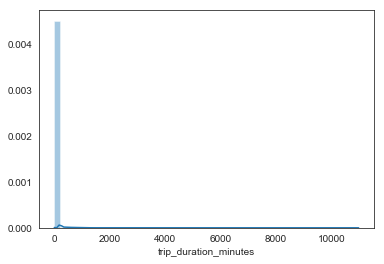

In [61]:
sns.distplot(bcycle['trip_duration_minutes'], hist=True)

In [62]:
bcycle['<1000_mins'] = np.where(bcycle['trip_duration_minutes']<1000, True, False)

In [63]:
bcycle_1_day = bcycle.loc[(bcycle['trip_duration_minutes'] <= 1000)]

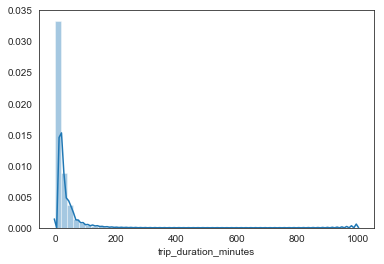

In [64]:
sns.distplot(bcycle_1_day['trip_duration_minutes'], hist=True)

In [65]:
bcycle['<=200_mins'] = np.where(bcycle['trip_duration_minutes']<=200, True, False)

In [66]:
bcycle_200_mins = bcycle.loc[(bcycle['trip_duration_minutes'] <= 200)]

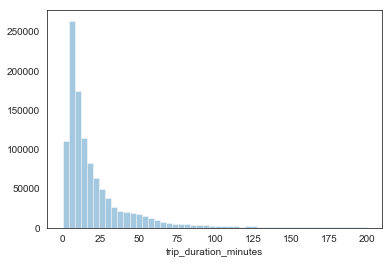

In [67]:
sns.distplot(bcycle_200_mins['trip_duration_minutes'], hist=True, kde = False)

In [68]:
bcycle['<=20_mins'] = np.where(bcycle['trip_duration_minutes']<=20, True, False)

In [69]:
bcycle_20_mins = bcycle.loc[(bcycle['trip_duration_minutes'] <= 20)]

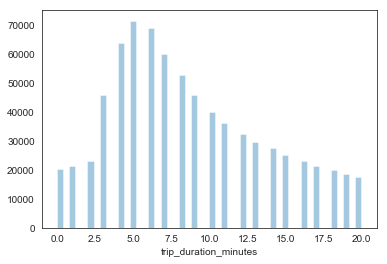

In [70]:
sns.distplot(bcycle_20_mins['trip_duration_minutes'], hist=True, kde = False)

In [71]:
bcycle_200_mins['trip_duration_minutes'].count()

1108173

In [72]:
bcycle['trip_duration_minutes'].count()

1122091

In [73]:
bcycle['trip_duration_minutes'].value_counts()

5       71378
6       68857
4       63819
7       59775
8       52744
9       45871
3       45813
10      40063
11      36135
12      32354
13      29470
14      27370
15      25010
16      23186
2       22915
        ...  
1320        1
2345        1
1319        1
1318        1
2834        1
1316        1
3355        1
1812        1
1315        1
1814        1
4891        1
1308        1
1307        1
1818        1
1272        1
Name: trip_duration_minutes, Length: 1728, dtype: int64

______________________________________________________________________________________________________________________

______________________________________________________________________________________________________________________

______________________________________________________________________________________________________________________


# Dockless Section

## There are 5.44 millions dockless rides and a very small amount of rows with NaN's

In [74]:
#visual aid for the rows with NaN's
dockless.isnull().sum()

ID                            0
Device ID                     0
Vehicle Type                  1
Trip Duration                 1
Trip Distance                 1
Start Time                    1
End Time                      1
Modified Date                 0
Month                         1
Hour                          1
Day of Week                   1
Council District (Start)    186
Council District (End)      186
Year                          1
Census Tract Start          188
Census Tract End            188
dtype: int64

In [75]:
# creating and printing the variable for the original number of rides in the dataset (including NaN's)
dockless_rides = len(dockless)
print(dockless_rides)

5442039


## How many unique rows have NaN's ?

In [76]:
# drop rows with NaN's
dockless = dockless.dropna(axis=0)

In [77]:
# confirmation all rows with NaN's are dropped
dockless.isnull().sum()

ID                          0
Device ID                   0
Vehicle Type                0
Trip Duration               0
Trip Distance               0
Start Time                  0
End Time                    0
Modified Date               0
Month                       0
Hour                        0
Day of Week                 0
Council District (Start)    0
Council District (End)      0
Year                        0
Census Tract Start          0
Census Tract End            0
dtype: int64

In [78]:
# creating and printing the variable for the number of rides in the dataset without NaN's
dockless_no_nans = len(dockless)
print(dockless_no_nans)

5441851


## 99.99% of the rides in this dataset don't have NaN values so we can safely drop the rows with NaN's.

In [79]:
nan_dockless_percent = dockless_no_nans / dockless_rides
print("There are {} rides without NaN values out of {} total rides, which is equal to {}."
      .format(dockless_no_nans, dockless_rides, nan_dockless_percent))

There are 5441851 rides without NaN values out of 5442039 total rides, which is equal to 0.9999654541248234.


# Cleaning up columns

In [80]:
# data clean columns: 
dockless.columns = dockless.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

## We can drop the modified_date columnsince it is just the date that, according to the AustinTexas.gov website:
## "The [modified_date is when]...the record was last modified (typically the date the data was extracted/loaded from the data provider), in local time (US/Central)."

In [81]:
dockless.drop(['modified_date'], axis=1, errors='coerce', inplace=True)

## Convert start/end time using to_datetime into a Unix timestamp

In [82]:
dockless.head(1)

,id,device_id,vehicle_type,trip_duration,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,census_tract_start,census_tract_end
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,170.0,0.0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4.0,17.0,1.0,9.0,9.0,2019.0,4.8453e+10,48453000601


In [83]:
dockless.iloc[0].start_time

'04/29/2019 05:30:00 PM'

In [84]:
type(dockless.iloc[0].start_time)

str

In [85]:
from datetime import datetime
d = datetime.strptime('04/29/2019 05:30:00 PM', '%m/%d/%Y %I:%M:%S %p')
type(d)
d.strftime('%s')

'1556577000'

In [86]:
def str_to_timestamp(str):
    d = datetime.strptime(str, '%m/%d/%Y %I:%M:%S %p')
    return d.strftime('%s')

In [87]:
str_to_timestamp('04/29/2019 05:30:00 PM')

'1556577000'

In [88]:
#convert start time to unix timestamp
dockless.start_time.apply(str_to_timestamp)

2          1556577000
3          1556577000
4          1556576100
5          1556577000
6          1556577000
7          1556575200
8          1556577000
9          1556576100
10         1556577000
11         1556577000
12         1556576100
13         1556576100
14         1556577000
15         1556577900
16         1556578800
              ...    
5442024    1548538200
5442025    1548538200
5442026    1548538200
5442027    1548538200
5442028    1548538200
5442029    1548538200
5442030    1548538200
5442031    1548538200
5442032    1548538200
5442033    1547764200
5442034    1552418100
5442035    1547764200
5442036    1551221100
5442037    1551221100
5442038    1552196700
Name: start_time, Length: 5441851, dtype: object

In [89]:
#convert end time to unix timestamp
dockless.end_time.apply(str_to_timestamp)

2          1556577000
3          1556577000
4          1556576100
5          1556577900
6          1556577000
7          1556575200
8          1556577900
9          1556577000
10         1556577900
11         1556577000
12         1556577000
13         1556577000
14         1556578800
15         1556577900
16         1556578800
              ...    
5442024    1548538200
5442025    1548538200
5442026    1548538200
5442027    1548538200
5442028    1548538200
5442029    1548538200
5442030    1548538200
5442031    1548538200
5442032    1548538200
5442033    1547766900
5442034    1552419000
5442035    1547767800
5442036    1551221100
5442037    1551221100
5442038    1552197600
Name: end_time, Length: 5441851, dtype: object

In [90]:
# memory calc for dockless data set
for dtype in ['float','int','object']:
    selected_dtype = dockless.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
print("Average memory usage for {} columns: {:03.2f}MB".format(dtype,mean_usage_mb))

Average memory usage for object columns: 375.39MB


In [91]:
dockless.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5441851 entries, 2 to 5442038
Data columns (total 15 columns):
id                        object
device_id                 object
vehicle_type              object
trip_duration             float64
trip_distance             float64
start_time                object
end_time                  object
month                     float64
hour                      float64
day_of_week               float64
council_district_start    float64
council_district_end      float64
year                      float64
census_tract_start        object
census_tract_end          object
dtypes: float64(8), object(7)
memory usage: 3.3 GB


## For the most part, all the trips start and end in the same Council District, with the exception being zone Zero starting at 5th place but ending at 8th.

In [92]:
len(dockless)

5441851

In [93]:
dockless['council_district_start'].value_counts()

9.0     4262555
3.0      498504
1.0      327468
5.0      189368
0.0       41656
7.0       37811
8.0       33117
10.0      28544
4.0       16669
2.0        5672
6.0         487
Name: council_district_start, dtype: int64

In [94]:
dockless['council_district_end'].value_counts()

9.0     4191987
3.0      514803
1.0      362081
5.0      203877
7.0       38961
8.0       38768
10.0      32538
0.0       31674
4.0       19330
2.0        7348
6.0         484
Name: council_district_end, dtype: int64

## Masking

In [95]:
mask = dockless['council_district_start'] == 0.0

In [96]:
dockless[mask]

,id,device_id,vehicle_type,trip_duration,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,census_tract_start,census_tract_end
28378,3a3a83a2-afba-4985-89d1-526b12d13b48,629d8f0e-2327-4b0f-aa0c-32e2ae56824a,scooter,1201.0,5297.0,06/11/2019 12:45:00 PM,06/11/2019 01:00:00 PM,6.0,12.0,2.0,0.0,5.0,2019.0,4.8453e+10,48453002004
47930,fff229c0-b275-4fc0-8632-c83849e8ab59,cfad9625-bac7-4a26-a4c7-2462972ae7f1,scooter,758.0,33443.0,05/05/2019 10:30:00 AM,05/05/2019 10:45:00 AM,5.0,10.0,0.0,0.0,9.0,2019.0,48055960101,48453001100
64771,049cbca1-49dd-4a24-94b1-a64965e94c50,cf621c46-e694-473e-9e19-e54978cb4aa0,scooter,84.0,62.0,04/27/2019 08:45:00 PM,04/27/2019 08:45:00 PM,4.0,20.0,6.0,0.0,0.0,2019.0,48453001917,48453001914
65245,6ea7c070-23d2-4f2d-8d9c-d765aa605df0,8796adb0-e212-4faa-b4a5-2391fad02921,scooter,210.0,17354.0,05/05/2019 11:15:00 AM,05/05/2019 11:15:00 AM,5.0,11.0,0.0,0.0,9.0,2019.0,48453002207,48453001100
65371,c7a49b0f-1dd9-4e3a-a7d3-5da4ba33b11a,d39c5f09-cd06-4a75-8d02-8acab89d0d57,scooter,1175.0,19138.0,05/05/2019 11:15:00 AM,05/05/2019 11:30:00 AM,5.0,11.0,0.0,0.0,1.0,2019.0,48453002207,48453001100
88064,10e289c1-d513-4dbb-8fba-7412677daec0,3cac4ce8-a6b2-4b20-8835-d04f8909643a,scooter,345.0,1080.0,05/19/2019 08:30:00 PM,05/19/2019 08:45:00 PM,5.0,20.0,0.0,0.0,8.0,2019.0,48453001910,48453001910
94633,724b0d29-1704-4bdd-be57-6bb39ef55d0f,b49165de-56d0-43ad-bdb9-9f58bb1f9036,scooter,242.0,83979.0,04/30/2019 02:15:00 PM,04/30/2019 02:15:00 PM,4.0,14.0,2.0,0.0,9.0,2019.0,OUT_OF_BOUNDS,48453000604
97619,7acb679f-3c44-4407-8053-a2002a1421b6,c9524668-d706-4e4b-afb1-3e6ed61b5401,scooter,81.0,399.0,06/11/2019 02:15:00 PM,06/11/2019 02:15:00 PM,6.0,14.0,2.0,0.0,0.0,2019.0,48453001919,48453001919
99012,8a071edc-a3fa-4f43-9e30-10494dc626a2,2cbb3fed-1494-4095-b9db-f31a29b64bdf,scooter,362.0,30986.0,05/05/2019 01:30:00 PM,05/05/2019 01:45:00 PM,5.0,13.0,0.0,0.0,9.0,2019.0,48021950802,48453000603
113666,e2688917-5ef7-475c-97bd-a9dc83a60b74,d49d7246-2fbb-4eb7-a8a5-5c142cedba39,scooter,209.0,101.0,04/25/2019 05:30:00 PM,04/25/2019 05:30:00 PM,4.0,17.0,4.0,0.0,0.0,2019.0,48453001919,48453001919


## According to the maps, there are only 10 Council Districts yet there are 11 districts in the data.

In [97]:
dockless.groupby('council_district_start').size()

council_district_start
0.0       41656
1.0      327468
2.0        5672
3.0      498504
4.0       16669
5.0      189368
6.0         487
7.0       37811
8.0       33117
9.0     4262555
10.0      28544
dtype: int64

In [98]:
dockless.groupby('council_district_end').size()

council_district_end
0.0       31674
1.0      362081
2.0        7348
3.0      514803
4.0       19330
5.0      203877
6.0         484
7.0       38961
8.0       38768
9.0     4191987
10.0      32538
dtype: int64

## Since the zones 9,3,1, and 5 are either part of Downtown Austin or adjacent to it, it is safe to say that the Districts are ordered numerically and zone zero may be used as a substitute for NaN or an unknown.

In [99]:
zone_zero_percent = dockless_no_nans / dockless_rides
print("There are {} rides without NaN values out of {} total rides, which is equal to {}."
      .format(dockless_no_nans, dockless_rides, nan_dockless_percent))

There are 5441851 rides without NaN values out of 5442039 total rides, which is equal to 0.9999654541248234.


In [100]:
#keeps only rows without 0.0 (drops due to more advanced requirements)
dockless = dockless[(dockless['council_district_start'] != 0.0) & (dockless['council_district_end'] != 0.0)]

In [101]:
dockless_0_drop = len(dockless)
print(dockless_0_drop)

5385031


In [102]:
# confirm new values
dockless['council_district_start'].value_counts()

9.0     4251227
3.0      497481
1.0      326440
5.0      188567
7.0       37370
8.0       32900
10.0      28399
4.0       16561
2.0        5621
6.0         465
Name: council_district_start, dtype: int64

In [103]:
# confirm new values
dockless['council_district_end'].value_counts()

9.0     4173210
3.0      512446
1.0      360235
5.0      202706
8.0       38546
7.0       38478
10.0      32383
4.0       19234
2.0        7316
6.0         477
Name: council_district_end, dtype: int64

## Even without those rows, we only dropped 1.04% of the original dataframe

In [104]:
dockless_0_percent = dockless_0_drop / dockless_rides
dockless_0_minus = (1-dockless_0_percent)
print("Even after dropping all the rows with 0.0, we still have {}% of the original dataframe, or just a {}% loss"
      .format(dockless_0_percent, dockless_0_minus))

Even after dropping all the rows with 0.0, we still have 0.9895245146166721% of the original dataframe, or just a 0.010475485383327876% loss


## Converting ID and Device_ID for consistency

In [105]:
dockless['id']= dockless['id'].astype(str)

In [106]:
dockless['device_id']= dockless['device_id'].astype(str)

In [107]:
dockless.dtypes

id                         object
device_id                  object
vehicle_type               object
trip_duration             float64
trip_distance             float64
start_time                 object
end_time                   object
month                     float64
hour                      float64
day_of_week               float64
council_district_start    float64
council_district_end      float64
year                      float64
census_tract_start         object
census_tract_end           object
dtype: object

## Convert columns to integers

In [108]:
dockless['trip_duration'] = pd.to_numeric(dockless['trip_duration'], errors='ignore', downcast='integer')

In [109]:
dockless['trip_distance'] = pd.to_numeric(dockless['trip_distance'], errors='ignore', downcast='integer')

In [110]:
dockless['month'] = pd.to_numeric(dockless['month'], errors='ignore', downcast='integer')

In [111]:
dockless['hour'] = pd.to_numeric(dockless['hour'], errors='ignore', downcast='integer')

In [112]:
dockless['day_of_week'] = pd.to_numeric(dockless['day_of_week'], errors='ignore', downcast='integer')

In [113]:
dockless['council_district_start'] = pd.to_numeric(dockless['council_district_start'], errors='ignore', downcast='integer')

In [114]:
dockless['council_district_end'] = pd.to_numeric(dockless['council_district_end'], errors='ignore', downcast='integer')

In [115]:
dockless['year'] = pd.to_numeric(dockless['year'], errors='ignore', downcast='integer')

In [116]:
dockless.sample(5)

,id,device_id,vehicle_type,trip_duration,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,census_tract_start,census_tract_end
1388134,6e500d1f-a4b5-4957-9eec-0b539a305b4d,3a6aa434-e197-4757-96f5-491943ebe879,scooter,437,0,10/13/2018 05:45:00 PM,10/13/2018 06:00:00 PM,10,17,6,5,5,2018,48453001303,48453001303
5157884,d6da23b6-8c21-429d-bed8-704257197640,474beff5-93f1-4639-a07d-0cad9b9cae2e,scooter,237,100,10/11/2018 12:30:00 PM,10/11/2018 12:45:00 PM,10,12,4,9,9,2018,48453000601,48453000601
1746758,b9fffe67-82c5-492f-8aa3-a0c0e40d3e80,5f38c92b-8616-4665-8f2d-becce272c6cb,scooter,1718,3307,01/12/2019 04:30:00 PM,01/12/2019 05:00:00 PM,1,16,6,9,9,2019,48453001100,48453001305
292300,16de880b-836a-4d07-babc-8df0fa062d7d,314aadf8-96e9-4956-b9fe-2fe198a671e8,scooter,1281,1299,05/17/2019 10:45:00 PM,05/17/2019 11:00:00 PM,5,22,5,9,9,2019,48453001100,48453001100
4066087,a1b976a3-3fae-4030-8cb0-de6f81ebcca8,563ae410-0926-4f21-9b4c-fab588a34124,scooter,486,1765,08/28/2018 09:00:00 PM,08/28/2018 09:15:00 PM,8,21,2,9,9,2018,48453001100,48453001100


In [117]:
dockless.dtypes

id                        object
device_id                 object
vehicle_type              object
trip_duration              int32
trip_distance              int32
start_time                object
end_time                  object
month                       int8
hour                        int8
day_of_week                 int8
council_district_start      int8
council_district_end        int8
year                       int16
census_tract_start        object
census_tract_end          object
dtype: object

## Census GEOID cleanup

In [118]:
dockless['census_tract_end'] = dockless.census_tract_end.astype(float)

In [119]:
dockless['census_tract_start'] = dockless.census_tract_end.astype(float)

In [120]:
dockless['census_tract_start'] = pd.to_numeric(dockless['census_tract_start'], errors='ignore', downcast='integer')

In [121]:
dockless['census_tract_end'] = pd.to_numeric(dockless['census_tract_end'], errors='ignore', downcast='integer')

In [122]:
dockless.dtypes

id                        object
device_id                 object
vehicle_type              object
trip_duration              int32
trip_distance              int32
start_time                object
end_time                  object
month                       int8
hour                        int8
day_of_week                 int8
council_district_start      int8
council_district_end        int8
year                       int16
census_tract_start         int64
census_tract_end           int64
dtype: object

In [123]:
dockless.sample(5)

,id,device_id,vehicle_type,trip_duration,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,census_tract_start,census_tract_end
2907213,c26c2423-f7f6-42c0-b3f5-024fd9a00858,159a10a6-e020-4d25-841b-277eef263439,scooter,221,0,10/18/2018 12:15:00 PM,10/18/2018 12:15:00 PM,10,12,4,9,9,2018,48453000604,48453000604
1518249,d51bba6b-527e-4ed0-b558-1f034648ef70,9202f2f7-ce10-4ad3-9067-122f683dc1f5,scooter,298,705,08/01/2018 08:30:00 PM,08/01/2018 08:30:00 PM,8,20,3,9,9,2018,48453000700,48453000700
544394,99ead01a-1ba2-499f-b3cb-b5f5e6f08220,4ce8824b-2f31-4c38-b6ad-46e476a51df9,scooter,121,257,05/09/2019 04:00:00 PM,05/09/2019 04:00:00 PM,5,16,4,9,9,2019,48453000604,48453000604
2112399,2c901a1a-538e-4323-99cb-2d9e65fe0d12,1175bfa9-0709-4e4e-986c-d88c3155ef54,scooter,357,96,02/24/2019 09:00:00 PM,02/24/2019 09:00:00 PM,2,21,0,9,9,2019,48453000601,48453000601
117186,c80f352e-677b-4532-af09-2c951fb885c3,2aa0effc-cb1e-4cd0-982b-12a91eb8ec90,scooter,774,2510,04/25/2019 08:45:00 PM,04/25/2019 09:00:00 PM,4,20,4,9,1,2019,48453000901,48453000901


## Vehicle type analysis and conversion to get_dummies

## Converted Scooter = 0 and Bike = 1

In [124]:
dockless['vehicle_type'] = pd.get_dummies(dockless['vehicle_type'])

In [125]:
dockless.vehicle_type.value_counts()

0    5123501
1     261530
Name: vehicle_type, dtype: int64

## ~95% of all dockless vehicle rides are Scooters

In [126]:
dockless.vehicle_type.value_counts(1)

0    0.951434
1    0.048566
Name: vehicle_type, dtype: float64

## Drop GEO-ID columns

In [127]:
dockless.drop(['census_tract_start'], axis=1, errors='coerce', inplace=True)

In [128]:
dockless.drop(['census_tract_end'], axis=1, errors='coerce', inplace=True)

## Create a column so time values are consistent in minutes and secondsmin both datasets

In [129]:
dockless.rename(columns={'trip_duration':'trip_duration_seconds'}, inplace=True)

In [130]:
dockless['trip_duration_minutes'] = dockless['trip_duration_seconds'] / 60
dockless['trip_duration_minutes']

2           2.833333
3           1.500000
4           9.500000
5           7.300000
6           6.516667
7           2.550000
8           9.500000
9          11.133333
10          6.500000
11          7.200000
12          3.266667
13         10.366667
14         20.400000
15          3.633333
16          1.716667
             ...    
5442024     6.016667
5442025     5.850000
5442026     8.083333
5442027     2.550000
5442028     1.250000
5442029     6.100000
5442030     0.850000
5442031     1.216667
5442032     5.000000
5442033    50.366667
5442034    15.650000
5442035    63.183333
5442036     2.650000
5442037     2.183333
5442038     7.783333
Name: trip_duration_minutes, Length: 5385031, dtype: float64

In [131]:
dockless.head()

,id,device_id,vehicle_type,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,trip_duration_minutes
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,0,170,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,2.833333
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,0,90,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,1.500000
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,0,570,826,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4,17,1,9,9,2019,9.500000
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,0,438,1815,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4,17,1,9,9,2019,7.300000
6,e1ac0e42-ab2d-4eac-b019-f085169c1d38,1d89f9e2-d01a-4736-b7d8-258cb9a2108c,0,391,1519,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,6.516667


In [132]:
dockless = dockless[['id', 'device_id', 'vehicle_type', 'trip_duration_minutes','trip_duration_seconds',
                    'trip_distance', 'start_time', 'end_time', 'month', 'hour', 'day_of_week',
                    'council_district_start', 'council_district_end', 'year']]

## I have a lot of negative values that are affecting the distribution

## Negative time

In [133]:
dockless[dockless['trip_duration_seconds']<0].count()

id                        6
device_id                 6
vehicle_type              6
trip_duration_minutes     6
trip_duration_seconds     6
trip_distance             6
start_time                6
end_time                  6
month                     6
hour                      6
day_of_week               6
council_district_start    6
council_district_end      6
year                      6
dtype: int64

In [134]:
indices = dockless[dockless['trip_duration_seconds']<0].index.tolist()
dockless.drop(indices, axis=0, inplace=True)

In [135]:
dockless[dockless['trip_duration_seconds']<0].count()

id                        0
device_id                 0
vehicle_type              0
trip_duration_minutes     0
trip_duration_seconds     0
trip_distance             0
start_time                0
end_time                  0
month                     0
hour                      0
day_of_week               0
council_district_start    0
council_district_end      0
year                      0
dtype: int64

## negative distance

In [207]:
dockless[dockless['trip_distance']<0].count()

id                        503
device_id                 503
vehicle_type              503
trip_duration_minutes     503
trip_duration_seconds     503
trip_distance             503
start_time                503
end_time                  503
month                     503
hour                      503
day_of_week               503
council_district_start    503
council_district_end      503
year                      503
<=20_distance             503
dtype: int64

In [208]:
indices = dockless[dockless['trip_distance']<0].index.tolist()
dockless.drop(indices, axis=0, inplace=True)

In [209]:
dockless[dockless['trip_distance']<0].count()

id                        0
device_id                 0
vehicle_type              0
trip_duration_minutes     0
trip_duration_seconds     0
trip_distance             0
start_time                0
end_time                  0
month                     0
hour                      0
day_of_week               0
council_district_start    0
council_district_end      0
year                      0
<=20_distance             0
dtype: int64

## Creating formula for avg scooter distance

In [136]:
dockless.sample(1)

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year
3765024,fde9749d-2062-4723-95b0-81508cf2d3b7,2b813781-02e3-4041-a6d9-d0b8b00f2317,0,10.816667,649,2010,09/30/2018 07:15:00 PM,09/30/2018 07:30:00 PM,9,19,0,9,9,2018


In [137]:
# convert meters to miles
# https://www.metric-conversions.org/length/meters-to-miles.htm
to_miles = 0.00062137

## Listing the different scooter & bike manufacturers with their respectives ranges based on one full battery charge

In [138]:
# different manufactured types of scooters or bike w/ their ranges in miles based on one full battery charge
xiaomi = 15
jump_bike = 40
lime_s = 37
vespa = 50
veo_bike = 68

40 * 91% = 36.4
68 * 9% = 6.12
42.52

## List of all dockless companies with permits and ranges calculated

In [140]:
# Bird permits and scooter range
bird_permits_scooter = 1000
bird_range_scooter = xiaomi 

In [141]:
# JUMP permits and scooter/bike ranges
jump_permits_scooter = 500
jump_permits_bike = 500

jump_range_scooter = xiaomi 
jump_range_bike = jump_bike 

In [142]:
# Lime scooter permits and range
lime_permits_scooter = 500
lime_range_scooter = lime_s 

In [143]:
# Lyft scooter permits and range
lyft_permits_scooter = 500
lyft_range_scooter = xiaomi

In [144]:
# OjO scooter permits and range
ojo_permits_scooter = 100
ojo_range_scooter = vespa 

In [145]:
# Skip scooter permits and range
skip_permits_scooter = 500
skip_range_scooter = vespa 

In [146]:
# Spin scooter permits and range
spin_permits_scooter = 500
skip_range_scooter = xiaomi

In [147]:
# VeoRide scooter & bike permits and range
veo_permits_scooter = 300
veo_permits_bike = 50

veo_range_scooter = xiaomi 
veo_range_bike = veo_bike

pap8 - stipulate how code should look (4 tabs, etc)
all code < 80 characters

## Permit Totals

In [174]:
# formula for scooter permits
total_scooter_permits = (bird_permits_scooter + 
                         jump_permits_scooter + 
                         lime_permits_scooter + 
                         lyft_permits_scooter +
                         ojo_permits_scooter +
                         skip_permits_scooter + 
                         spin_permits_scooter + 
                         veo_permits_scooter)
print(total_scooter_permits)

3900


In [175]:
#formula for bike permits
total_bike_permits = (jump_permits_bike + veo_permits_bike)
print(total_bike_permits)

550


## Permit Percentages

In [172]:
# formulas for scooter weighted avg
bird_s_pct = bird_permits_scooter / total_scooter_permits
jump_s_pct = jump_permits_scooter / total_scooter_permits
lime_s_pct = lime_permits_scooter / total_scooter_permits
lyft_s_pct = lyft_permits_scooter / total_scooter_permits
ojo_s_pct = ojo_permits_scooter / total_scooter_permits
skip_s_pct = skip_permits_scooter / total_scooter_permits
spin_s_pct = spin_permits_scooter / total_scooter_permits
veo_s_pct = veo_permits_scooter / total_scooter_permits

In [173]:
# formulas for bike weighted avg
jump_b_pct = jump_permits_bike / total_bike_permits
veo_b_pct = veo_permits_bike / total_bike_permits
print(jump_b_pct)
print(veo_b_pct)

0.9090909090909091
0.09090909090909091


In [ ]:
## 

## Dockless Bike Weighted Avg

In [177]:
# formula for bike permits
weighted_bike_permits = [['veoride', veo_permits_bike, veo_bike, veo_b_pct], 
                      ['jump', jump_permits_bike, jump_bike, jump_b_pct]]

bike_matrix = pd.DataFrame(total_bike_permits, columns=['vendor', 'bike_permit', 'bike_manuf', 'weight'])
print(total_bike_permits)

[['veoride', 50, 68, 0.09090909090909091], ['jump', 500, 40, 0.9090909090909091]]


In [ ]:
# formulas for bike weighted avg

In [184]:
dockless.head()

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,<=20_distance
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,0,2.833333,170,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,True
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,0,1.500000,90,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,True
4,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,0,9.500000,570,826,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4,17,1,9,9,2019,True
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,0,7.300000,438,1815,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4,17,1,9,9,2019,True
6,e1ac0e42-ab2d-4eac-b019-f085169c1d38,1d89f9e2-d01a-4736-b7d8-258cb9a2108c,0,6.516667,391,1519,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,True


In [210]:
dockless['<=20_distance'] = np.where(dockless['trip_distance']<=15373.8, True, False)
bcycle_20_distances = dockless.loc[(dockless['trip_distance'] <= 15373.8)]

In [211]:
df = dockless.loc[(dockless['trip_distance'] <= 15373.8)]
len(df)

5379848

In [212]:
len(dockless)

5384522

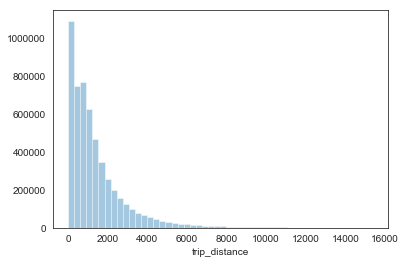

In [213]:
sns.distplot(df.trip_distance, hist=True, kde = False)

In [220]:
df.head(1)

,id,device_id,vehicle_type,trip_duration_minutes,trip_duration_seconds,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year,<=20_distance
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,0,2.833333,170,0,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,9,9,2019,True


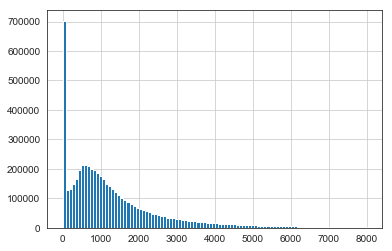

In [242]:
df.trip_distance.hist(bins=100, range=(0,8000))

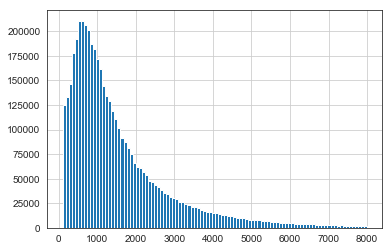

In [232]:
df.trip_distance.hist(bins=100, range=(100,8000))

## This plot proves false start are < 1 meter

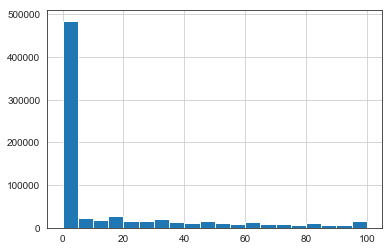

In [243]:
df.trip_distance.hist(bins=20, range=(0,100))

## <1% of the data extends beyond 8000 meters (4.87 mi)

In [246]:
dockless.loc[(dockless['trip_distance'] >= 8000)].count()

id                        49854
device_id                 49854
vehicle_type              49854
trip_duration_minutes     49854
trip_duration_seconds     49854
trip_distance             49854
start_time                49854
end_time                  49854
month                     49854
hour                      49854
day_of_week               49854
council_district_start    49854
council_district_end      49854
year                      49854
<=20_distance             49854
dtype: int64

In [257]:
49854 / len(dockless)

0.009258760573361944

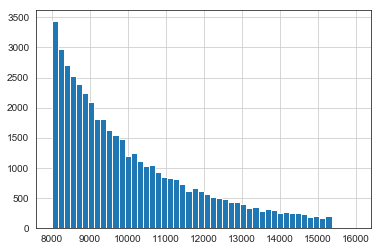

In [255]:
df.trip_distance.hist(bins=50, range=(8000, 16000))

In [155]:
scooter_data = [['veoride', veo_permits_scooter, veo_permits_bike, xiaomi, veo_bike, veo_permits_scooter/
                          total_scooter_permits, veo_permits_bike / total_bike_permits])



scooter_matrix = pd.DataFrame([['rideshare', 'permit_s', 'permit_b', 'manuf_s', 'manuf_b', 'weight_s', 'weight_b'],
                          'veoride', 
                               
print(scooter_matrix)

TypeError: object of type 'int' has no len()

In [ ]:
data = np.array([['','Col1','Col2'],
                ['Row1',1,2],
                ['Row2',3,4]])

In [177]:
permit_totals = [bird_permits_scooter, jump_permits_scooter, lime_permits_scooter, lyft_permits_scooter,
                        ojo_permits_scooter, skip_permits_scooter, spin_permits_scooter, veo_permits_scooter]

for permit in permit_totals:
    print(permit / total_scooter_permits)

0.2564102564102564
0.1282051282051282
0.1282051282051282
0.1282051282051282
0.02564102564102564
0.1282051282051282
0.1282051282051282
0.07692307692307693


In [ ]:
scooter_weighted_avg = [bird_range_scooter, ]
scooter permits = [all the permit totals, 1, 3, 4]

for g in range(len(rate)):
   rate[g] = rate[g] * amount[g] / sum(amount)
rate = sum(rate)

# Visualization & Exploration - Austin BCycle Program

In [119]:
bcycle.head(1)

,trip_id,membership_type,bicycle_id,checkout_date,checkout_time,checkout_kiosk_id,checkout_kiosk,return_kiosk_id,return_kiosk,trip_duration_minutes,trip_duration_seconds
0,9900285854,Annual (San Antonio B-cycle),207,2014-10-26,13:12:00,2537,West & 6th St.,2707,Rainey St @ Cummings,76,4560


In [118]:
bcycle_plot_prep = bcycle[['bicycle_id', 'checkout_date', 'checkout_time', 'checkout_kiosk_id', 
                           'return_kiosk_id', 'trip_duration_minutes', 'trip_duration_seconds']]

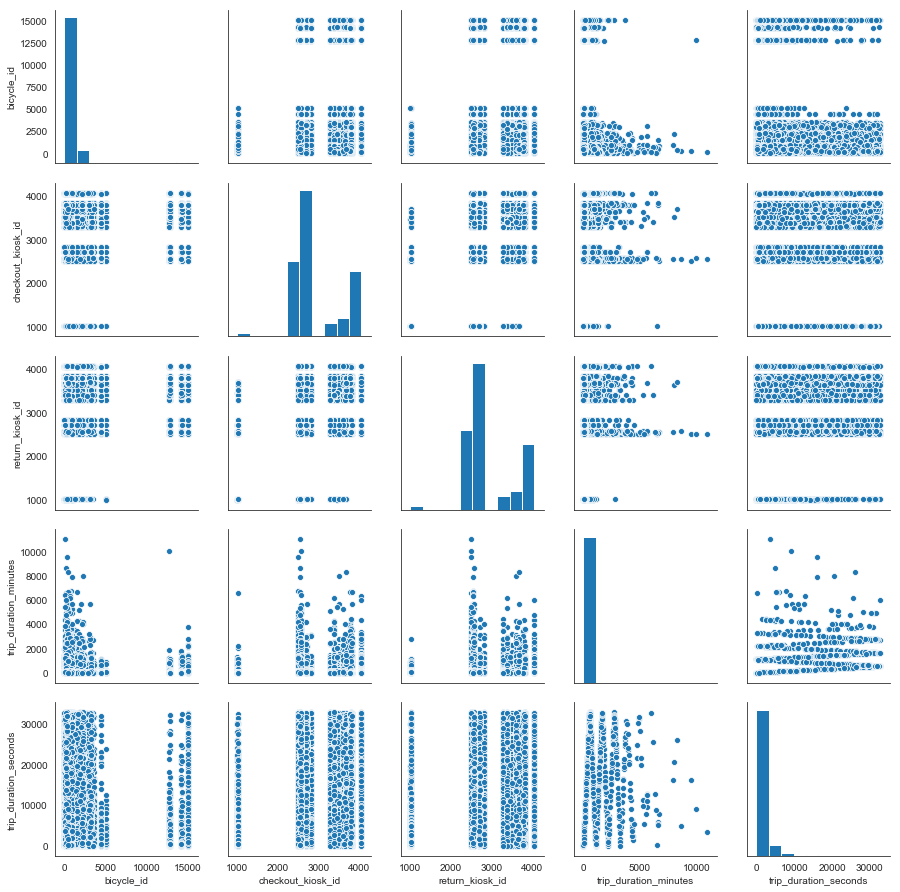

In [143]:
sns.pairplot(bcycle_plot_prep)

# Visualization & Exploration - Dockless Scooter & Bike Companies

In [122]:
dockless['trip_duration'].value_counts

<bound method IndexOpsMixin.value_counts of 2           170
3            90
4           570
5           438
6           391
7           153
8           570
9           668
10          390
11          432
12          196
13          622
14         1224
15          218
16          103
           ... 
5442024     361
5442025     351
5442026     485
5442027     153
5442028      75
5442029     366
5442030      51
5442031      73
5442032     300
5442033    3022
5442034     939
5442035    3791
5442036     159
5442037     131
5442038     467
Name: trip_duration, Length: 5385031, dtype: int32>

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


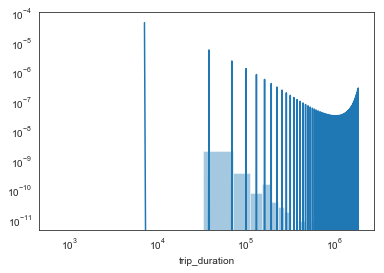

In [130]:
g = sns.distplot(dockless['trip_duration'], hist=True, hist_kws={'log':True})
g.set_xscale("log")

In [ ]:
sns.distplot(..., hist_kws={'log':True}

In [124]:
pair_prep = dockless[['vehicle_type', 'trip_distance', 'trip_duration', 'month', 'hour', 'day_of_week',
                     'council_district_start', 'council_district_end', 'year']]

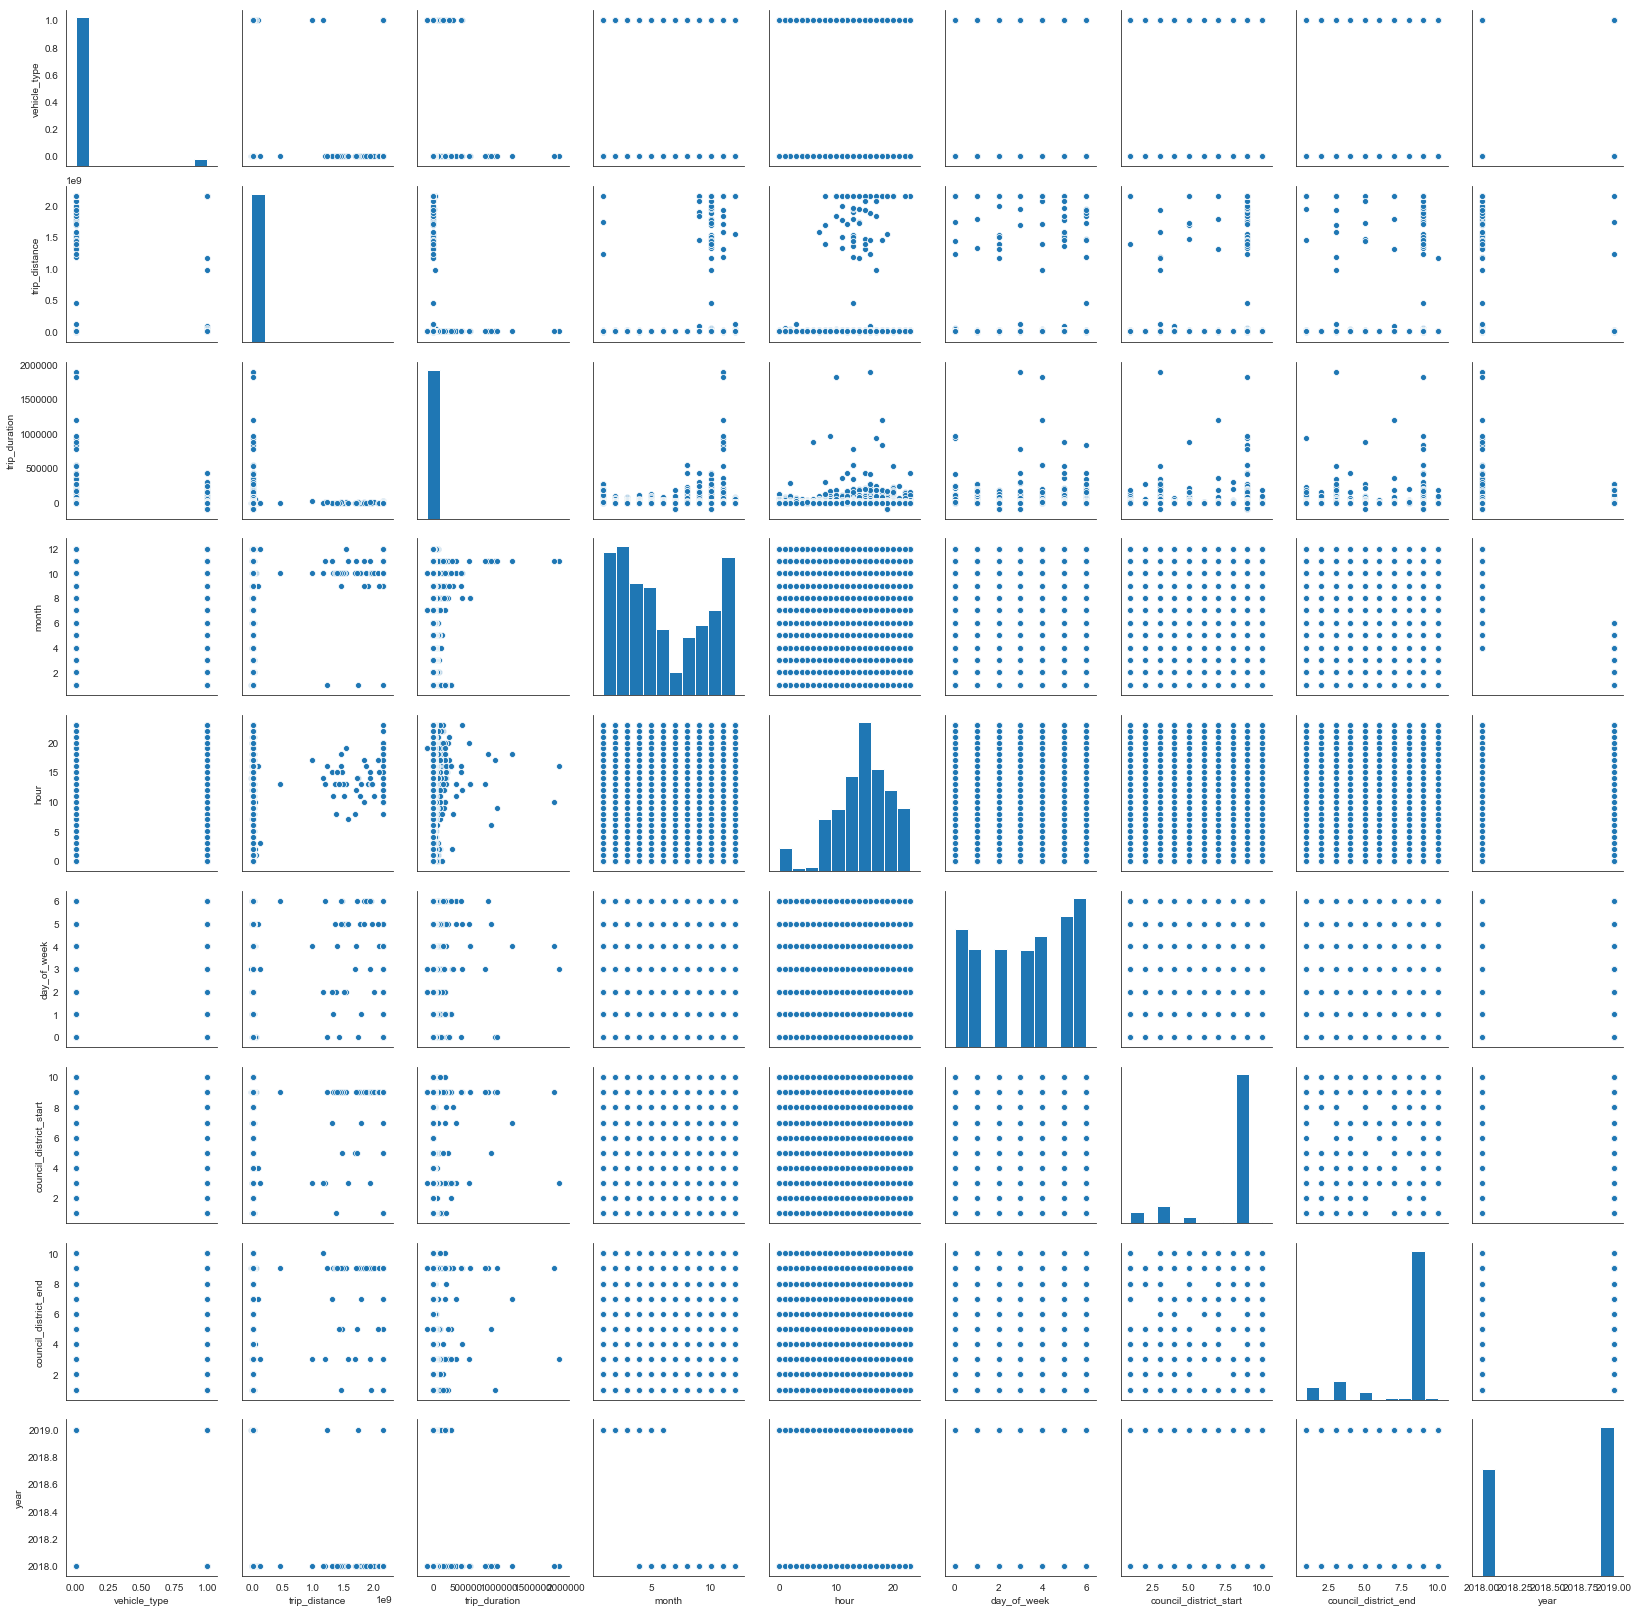

In [136]:
sns.pairplot(pair_prep)

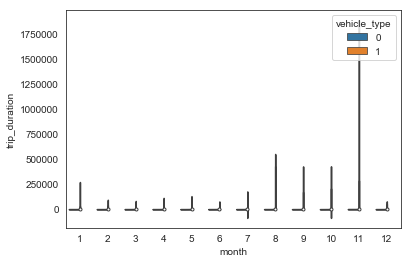

In [129]:
sns.violinplot(x="month",
                   y="trip_duration",
                   hue="vehicle_type",
                   data=dockless, gridsize=1000, height=12, scale='count', split=True)

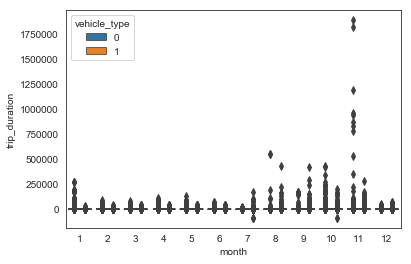

In [130]:
sns.boxplot(x="month",
                y="trip_duration",
                hue="vehicle_type",
                data=dockless, notch=True, whis=True)

KeyboardInterrupt: 

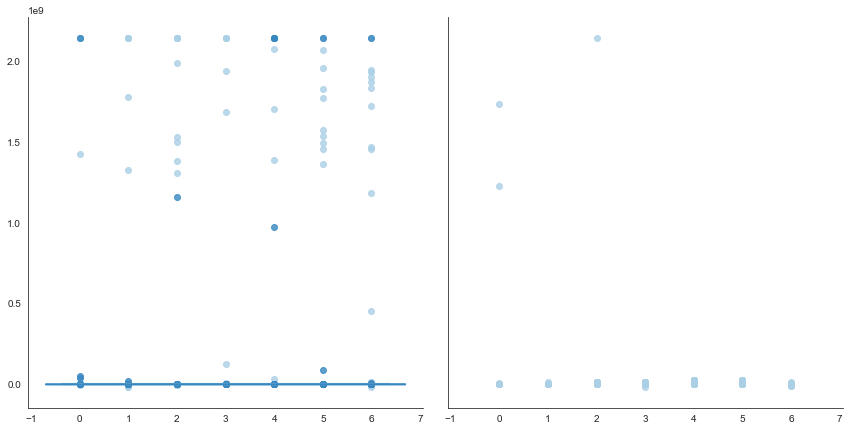

In [70]:
#linear regression + Facetgrid
facets = sns.lmplot(data=dockless, x="day_of_week", y="trip_duration_minutes", col="year", 
                    hue="vehicle_type", palette="Blues", height=6)
facets.add_legend()
facets = (facets.set_axis_labels("Trip Duration", "Trip Distance"))

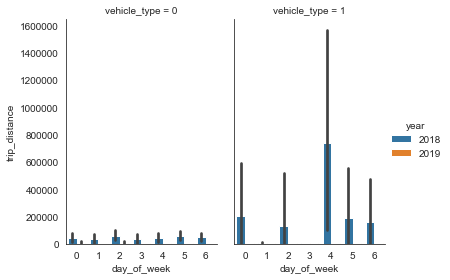

In [134]:
sns.catplot(x="day_of_week", y="trip_distance", hue="year", col="vehicle_type", data=dockless, 
            kind="bar", height=4, aspect=.7);


In [125]:
dockless[['trip_duration', 'trip_distance']].dtypes

trip_duration    int32
trip_distance    int32
dtype: object

In [168]:
dockless.sample(10)

,id,device_id,vehicle_type,trip_duration,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,year
4864743,37c9a897-7756-45da-a0bb-33c253ec4b95,5f5b071a-e8ba-4f39-ad7c-7c2959f913d5,0,449,2315,09/16/2018 09:15:00 AM,09/16/2018 09:30:00 AM,9,9,0,9,9,2018
436169,144d9282-902c-461a-8cf0-9b32ad295843,f6deb777-36be-4fd7-8b0b-0be5e0167680,0,184,708,05/24/2019 02:15:00 PM,05/24/2019 02:15:00 PM,5,14,5,9,9,2019
3690141,21235404-d6f2-4100-a2f3-f62af4a75e3f,2f62f729-d4a2-4f72-bfc6-59c31f454ce0,0,346,1167,08/28/2018 01:45:00 PM,08/28/2018 02:00:00 PM,8,13,2,9,9,2018
2682226,04ba8786-9eb3-4e6a-9df6-9ee110bd9709,bcb52b70-8be1-4681-b007-d70309f628f0,0,134,65,01/12/2019 05:45:00 PM,01/12/2019 05:45:00 PM,1,17,6,9,9,2019
4605254,c7f18ccc-f6f6-4fc2-a1ac-ce58932cde6d,3396e03c-5995-439f-8340-cd5e176a695a,0,203,563,03/17/2019 11:30:00 AM,03/17/2019 11:30:00 AM,3,11,0,5,9,2019
1982672,6cd6b66b-3b3e-4f28-b382-84719dd246a4,e472098f-62ac-4d3f-b26f-ebf6827d32fd,0,664,1326,02/23/2019 03:00:00 PM,02/23/2019 03:15:00 PM,2,15,6,9,9,2019
5366121,b7cdb801-956c-43f0-80a9-cb4f0dc5df45,95993c89-aefc-49a1-871e-aa14815e8036,0,476,1344,02/26/2019 04:15:00 PM,02/26/2019 04:30:00 PM,2,16,2,9,9,2019
3084311,9324802e-2422-4e1f-b831-3d55b09c6e27,428ea1c4-f489-4767-8a10-ad739833fc04,0,213,617,03/04/2019 10:45:00 AM,03/04/2019 10:45:00 AM,3,10,1,9,9,2019
5081117,6131ea1a-b6f4-4650-895c-e5cee7184ae3,bd358165-488f-494f-8665-c2cc1cc12bf4,0,470,1387,12/16/2018 11:30:00 AM,12/16/2018 11:30:00 AM,12,11,0,9,9,2018
2319316,d63b7a10-b636-40fb-a3c6-dd4a67d35695,d37b675b-e099-44f7-a548-c53bfff553da,0,425,2014,12/22/2018 01:45:00 PM,12/22/2018 01:45:00 PM,12,13,6,9,3,2018


In [ ]:
dockless['<=200_mins'] = np.where(dockless['trip_duration_seconds']<=1200, True, False)
dockless_200_mins = dockless.loc[(dockless['trip_duration_seconds'] <= 1200)]
sns.distplot(dockless_200_mins['trip_duration_seconds'], hist=True, kde=False)